<div style="width: 100%;">
    <div style="width: 100%; text-align: center; font-size: 30px; font-weight: bold;">
        Implementación Trabajo Final de Máster  
        <br>
        Predicción de tendencias en los precios de lonja del bovino 
        <br>
        usando técnicas de aprendizaje automático
    </div>
    <div style="width: 100%; text-align: center; font-size: 15px;">
        Víctor Jarreta Espligares
    </div>
</div>

## Análisis de los datos

Los datos numéricos que contienen los históricos de precios de la Lonja de Binéfar están divididos en dos archivos con formato CSV. Esta división se debe a un cambio en la forma de recopilar los datos. En el primer archivo, "datos1" tiene los datos desde 2015 hasta enero de 2024, mientras que el segundo archivo, "datos2" tiene los datos desde febrero de 2024 hasta diciembre de 2024. Por lo tanto, es necesario juntarlos en un solo archivo para poder trabajar con ellos. Además, los nombres de los productos son diferentes, aunque representan lo mismo, y por lo tanto el nombre de las columnas también es diferente.

Celda de código con las librerías necesarias para la ejecución del trabajo:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import ast
from sklearn.model_selection import train_test_split
import PyPDF2
import tensorflow as tf
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import optuna
import random
import os
from IPython.core.magic import register_cell_magic
from IPython import get_ipython
# Modificamos las semillas para que los resultados sean reproducibles
RANDOM_SEED = 8
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.keras.random.SeedGenerator(RANDOM_SEED)

Procedemos a crear una palabra Magic para excluir ciertas partes del código que darían error al ejecutar el notebook, por falta de acceso a algunos archivos de datos privados.

In [2]:
@register_cell_magic
def skip_if(line, cell):
    """
    Magic para evitar la ejecución de una celda si la condición en 'line' es True.
    Uso:
    %%skip_if condicion
    """
    if eval(line):
        print(f"Celda saltada.")
        return
    get_ipython().run_cell(cell)

In [3]:
skip_cell = True

In [14]:
%%skip_if skip_cell
# Cargamos el primer archivo
df_data = pd.read_csv('./datos/datos1.csv', sep=';')
df_data['Fecha'] = pd.to_datetime(df_data['Fecha'], utc=True)

# Eliminamos las columnas que no empiecen por 'Macho' o 'Hembra'
df_data = df_data[df_data.columns.drop(list(df_data.filter(regex='^(?!Fecha|Macho|Hembra)')))]
# Eliminamos todas las columnas que acaban en '_+' o '_-'
df_data = df_data[df_data.columns.drop(list(df_data.filter(regex='_\+')))]
df_data = df_data[df_data.columns.drop(list(df_data.filter(regex='_\-')))]
# Eliminamos el sufijo '_=' de las columnas
df_data.columns = df_data.columns.str.replace('_=', '')
# Cambiamos el caracter '_' por ' ' en los nombres de las columnas
df_data.columns = df_data.columns.str.replace('_', ' ')
# Cambiamos 'Machos' por 'male' y 'Hembra' por 'female'
df_data.columns = df_data.columns.str.replace('Machos', 'male ')
df_data.columns = df_data.columns.str.replace('Hembras', 'female ')
# Cambiamos 'Menos' por '<' y 'Mas' por '>'
df_data.columns = df_data.columns.str.replace('Menos', '<')
df_data.columns = df_data.columns.str.replace('Mas', '>')
# Cambiamos 'female >301' por 'female >300'
df_data.columns = df_data.columns.str.replace('female >301','female >300')
# Cambiamos el nombre de 'Fecha' por 'date'
df_data = df_data.rename(columns={'Fecha': 'date'})
# Cargamos el segundo archivo
df_prices = pd.read_csv('./datos/datos2.csv', sep=';')
df_prices['date'] = pd.to_datetime(df_prices['date'])
# Comprobamos cuántas columnas de ambos dataframes tienen el mismo nombre
common_columns = df_data.columns.intersection(df_prices.columns)
# Unimos los datos de ambos dataframes
# en las columnas que sean iguales
df_combined = pd.concat([df_data, df_prices]).drop_duplicates(subset='date')
# Eliminamos las columnas que tengan nulos
df_combined = df_combined.dropna(axis=1, how='any')
# Guardamos el dataframe unido en un archivo CSV
df_combined.to_csv('./datos/combinado.csv', index=False)
df_combined.describe()

C:\Users\VJarreta\AppData\Local\Temp\ipykernel_15836\3205995787.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_data['Fecha'] = pd.to_datetime(df_data['Fecha'], utc=True)


,male <280KG E,male <280KG U,male <280KG R,male <280KG O,male 281/320KG E,male 281/320KG U,male 281/320KG R,male 281/320KG O,male 321/370KG E,male 321/370KG U,...,female 221/260KG R,female 221/260KG O,female 261/300KG E,female 261/300KG U,female 261/300KG R,female 261/300KG O,female >300KG E,female >300KG U,female >300KG R,female >300KG O
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,...,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,4.781472,4.639738,4.341069,4.044335,4.765403,4.619980,4.303810,4.023165,4.693548,4.548669,...,4.726895,4.368286,4.920020,4.799032,4.524335,4.213609,4.893831,4.772984,4.510020,4.188125
std,0.533941,0.560941,0.620989,0.603707,0.532349,0.563105,0.639113,0.650227,0.565050,0.584715,...,0.451111,0.404242,0.493043,0.510042,0.550046,0.476703,0.507834,0.517348,0.544542,0.482533
min,4.050000,3.910000,3.630000,3.360000,4.060000,3.890000,3.580000,0.050000,3.980000,3.820000,...,4.000000,3.670000,4.170000,4.010000,3.770000,3.500000,4.130000,4.000000,3.780000,3.490000
25%,4.350000,4.210000,3.870000,3.600000,4.360000,4.190000,3.820000,3.595000,4.280000,4.120000,...,4.390000,4.060000,4.560000,4.430000,4.100000,3.830000,4.520000,4.390000,4.080000,3.790000
50%,4.590000,4.420000,4.050000,3.750000,4.570000,4.400000,4.000000,3.750000,4.460000,4.300000,...,4.610000,4.300000,4.800000,4.670000,4.340000,4.070000,4.760000,4.630000,4.320000,4.030000
75%,5.230000,5.180000,4.970000,4.730000,5.220000,5.142500,4.962500,4.720000,5.200000,5.120000,...,5.042500,4.720000,5.270000,5.170000,4.922500,4.630000,5.262500,5.145000,4.885000,4.602500
max,6.340000,6.190000,5.960000,5.520000,6.320000,6.190000,5.950000,5.520000,6.290000,6.180000,...,5.990000,5.410000,6.250000,6.160000,5.950000,5.380000,6.230000,6.130000,5.910000,5.380000


Una vez unidos los datos, se procede a realizar un análisis exploratorio de los mismos. Se visualizan los datos, se estudia la distribución de los mismos y posteriormente se estudia la correlación entre las variables

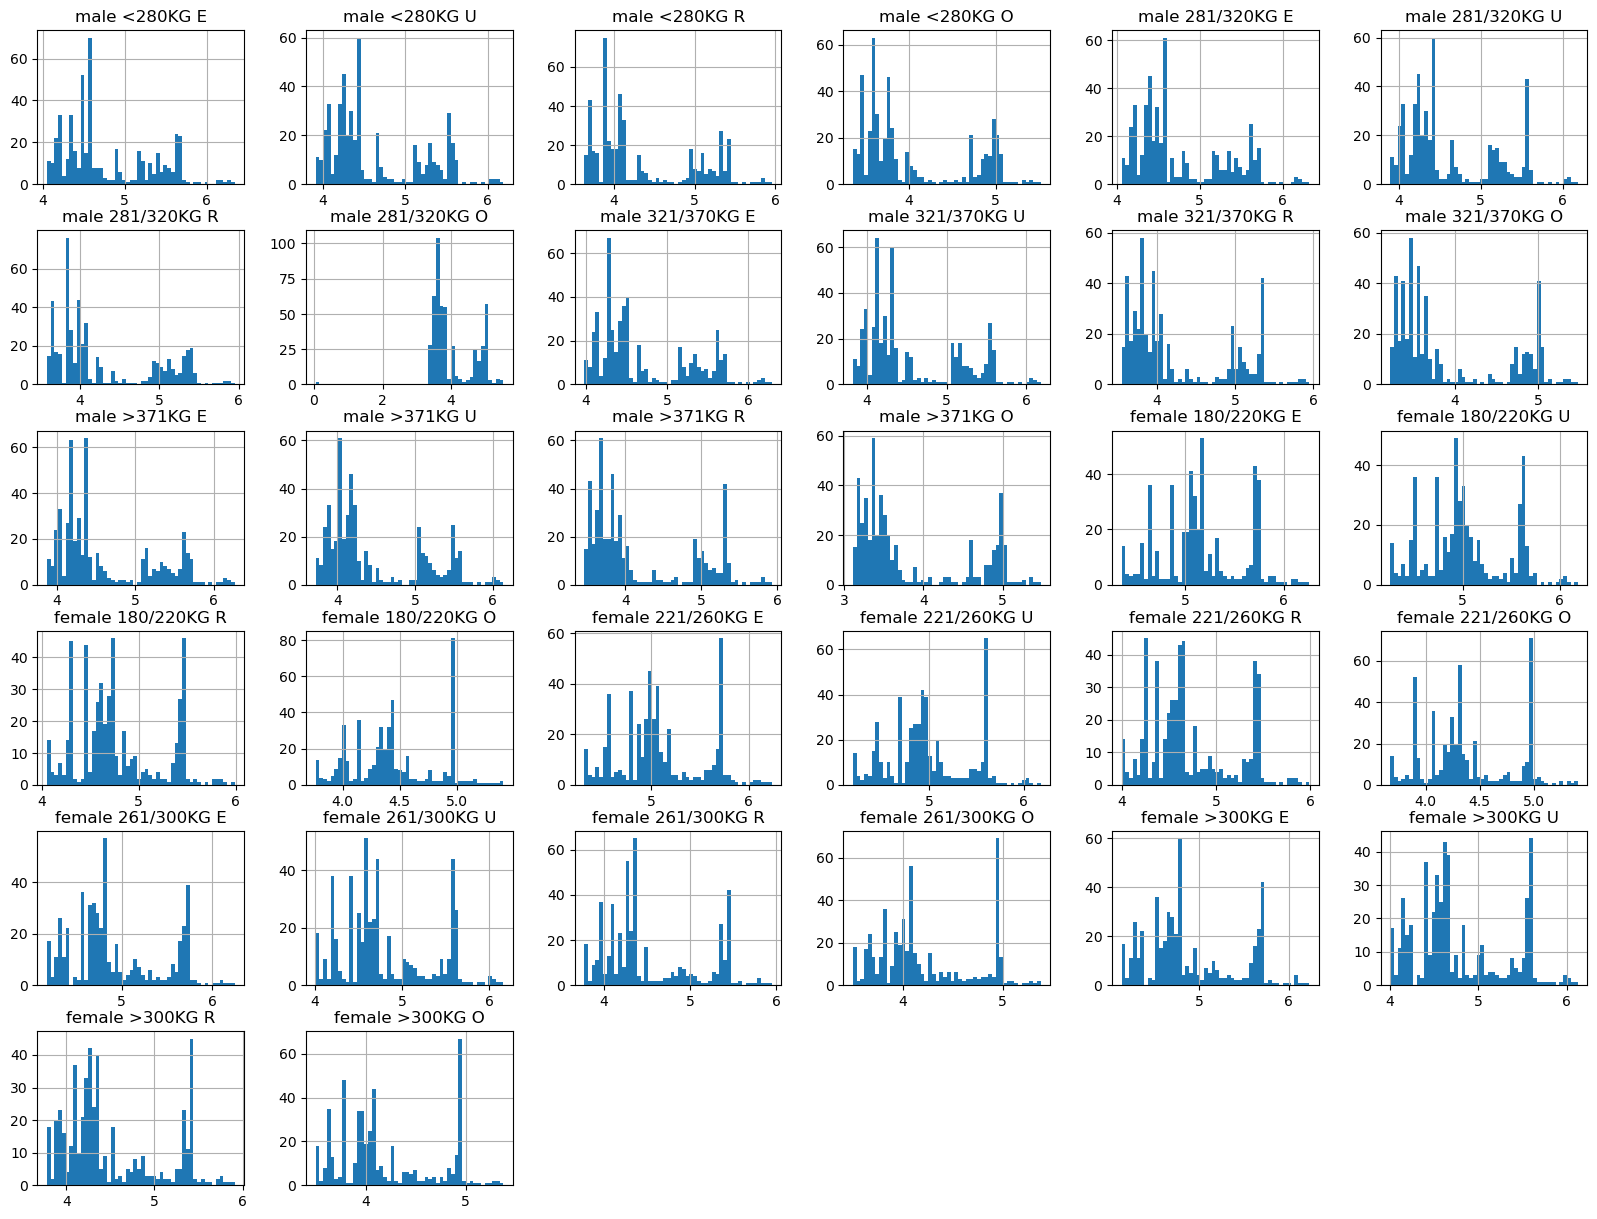

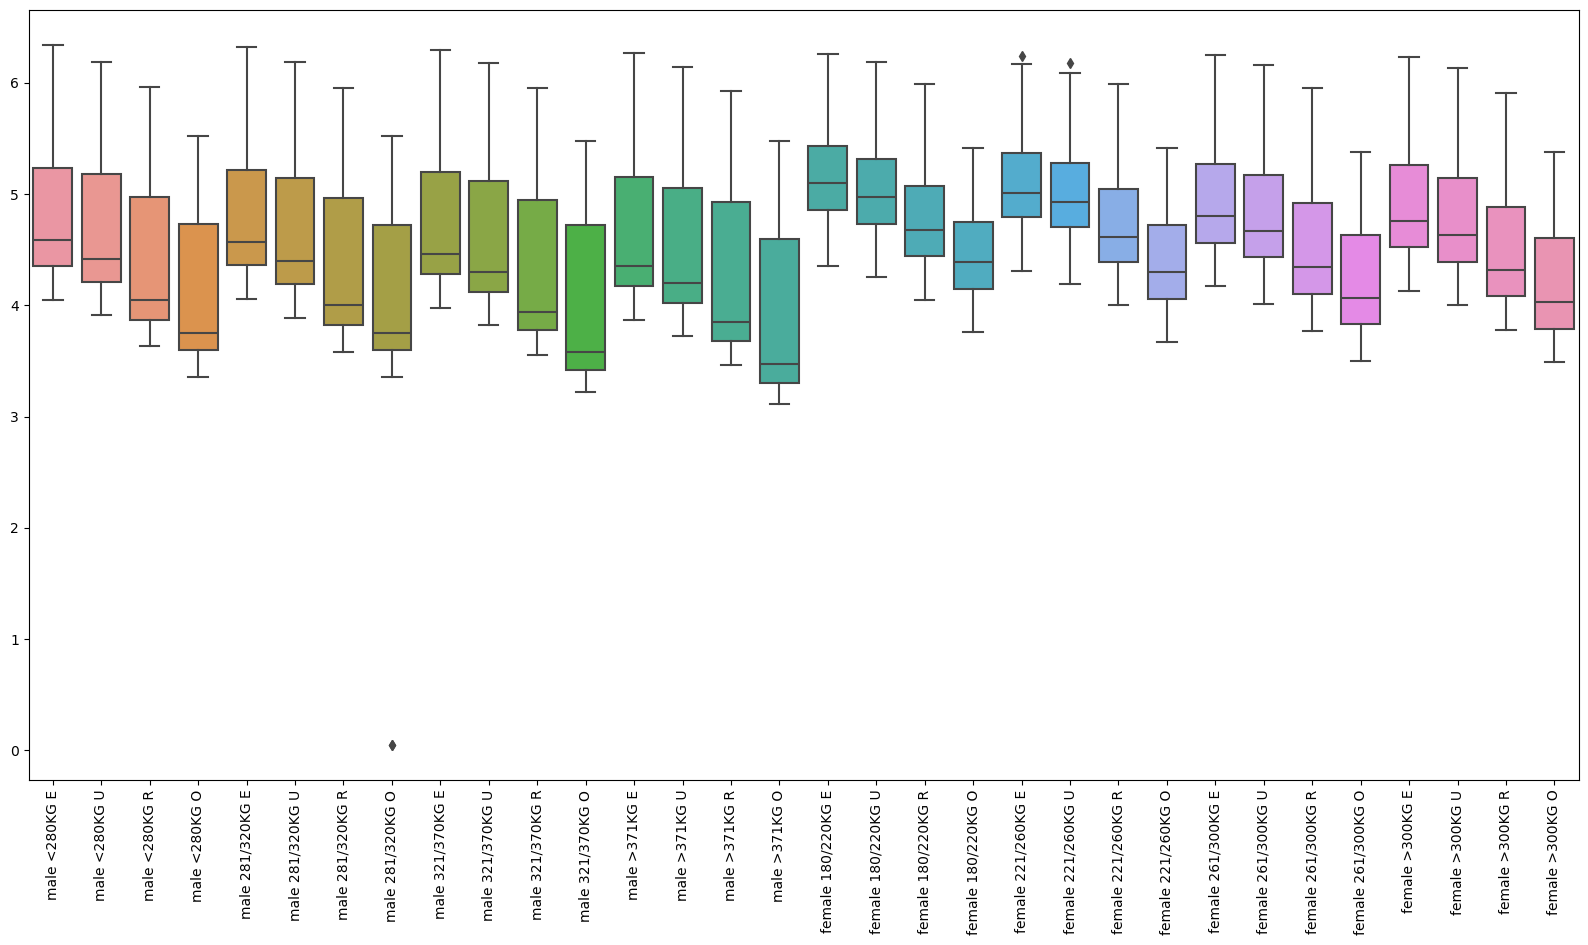

In [5]:
%%skip_if skip_cell
# Realizamos un análisis exploratorio de los datos
df_combined_data = df_combined.drop(columns=['date'])

# Distribución de las variables
df_combined_data.hist(bins=50, figsize=(20, 15))
plt.show()

# Mostramos en boxplots la distribución de las variables
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_combined_data)
plt.xticks(rotation=90)
plt.show()

Se puede observar que los datos no siguen una distribución reconocible. Además, gracias a los gráficos de caja, se puede apreciar al menos un outlier en "male 281/320KG O".

In [6]:
%%skip_if skip_cell
# Comprobamos el valor del outlier en "male 281/320KG O"
outlier_value = df_combined_data['male 281/320KG O'][df_combined_data['male 281/320KG O'] < 1]
print(outlier_value)
# Mostramos los valores cercanos a los índices 478 y 479
df_combined_data.iloc[475:485]['male 281/320KG O']

478    0.05
479    0.05
Name: male 281/320KG O, dtype: float64


475    4.99
476    4.99
477    5.00
478    0.05
479    0.05
480    5.00
481    5.00
482    5.02
483    5.03
484    5.05
Name: male 281/320KG O, dtype: float64

Tras comprobar los precios, se puede observar que el valor extremo es de '0.05', pero los valores cercanos son de '5.00', lo que indica un posible fallo humano al introducir los datos. Una vez consultado con los trabajadores de la lonja, se confirma que el valor correcto es '5.00', por lo que se procede a cambiar el valor erróneo.

In [7]:
%%skip_if skip_cell
# Cambiamos el valor de '0.05' por '5.00' en la columna 'male 281/320KG O'
df_combined.loc[df_combined_data['male 281/320KG O'] < 1, 'male 281/320KG O'] = 5.00
# Guardamos el dataframe unido en un archivo CSV
df_combined.to_csv('./datos/combinado.csv', index=False)

Como podemos ver en el gráfico de correlación, los productos de macho están muy correlacionados entre sí, lo que indica que la evolución de los precios de un producto de macho es similar a la de los demás productos de macho. Esto ocurre de igual forma con los productos de hembra. Pero los productos de macho y hembra parecen tener una menor correlación, aunque sigue siendo alta. 

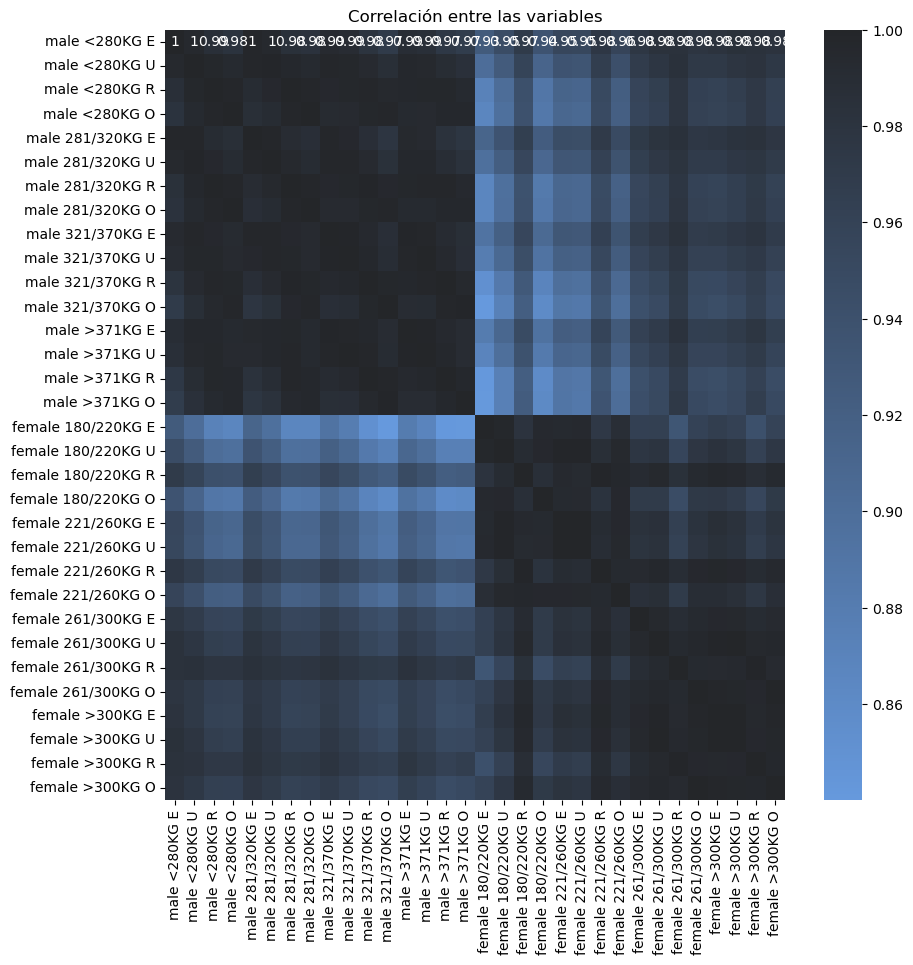

In [8]:
%%skip_if skip_cell
# Correlación
df_combined_data = df_combined.drop(columns=['date'])
correlation = df_combined_data.corr()
# Visualización de la correlación
plt.figure(figsize=(10, 10))
# sns.heatmap(correlation, annot=True, cmap=sns.color_palette('dark:salmon_r', as_cmap=True))
sns.heatmap(correlation, annot=True, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True))
plt.title('Correlación entre las variables')
plt.show()

Dividimos los datos en dos conjuntos, machos y hembras, para poder mostrar los gráficos de correlación de forma más clara.

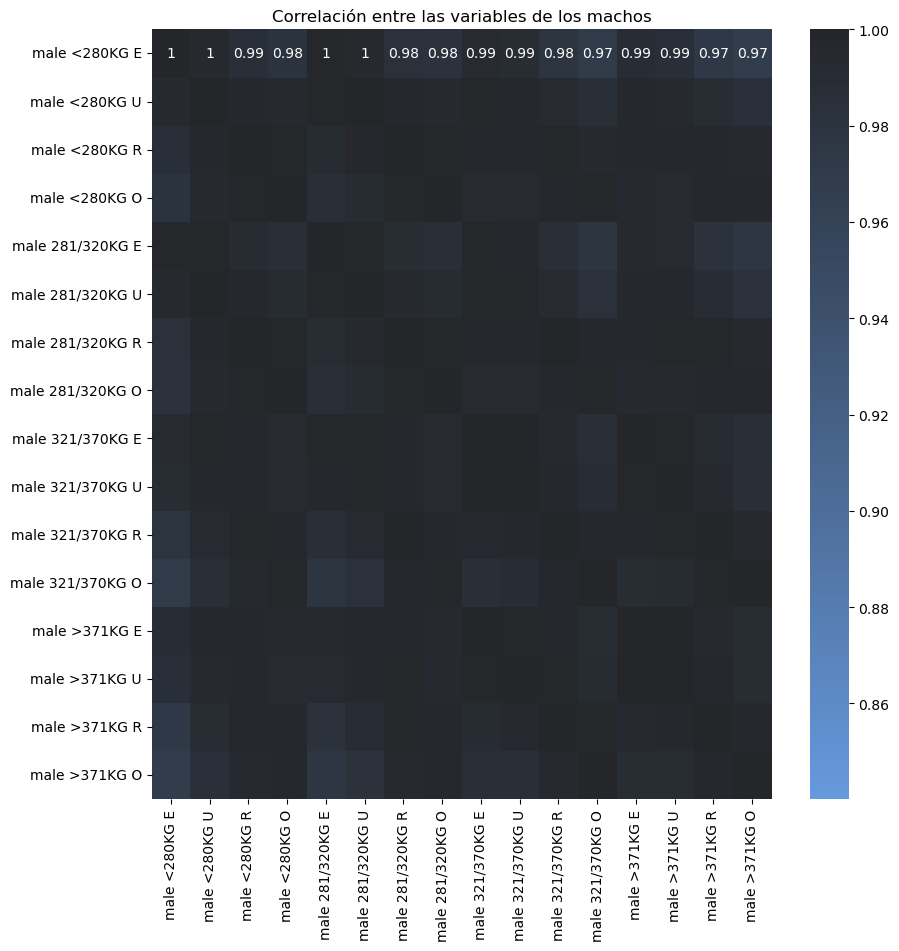

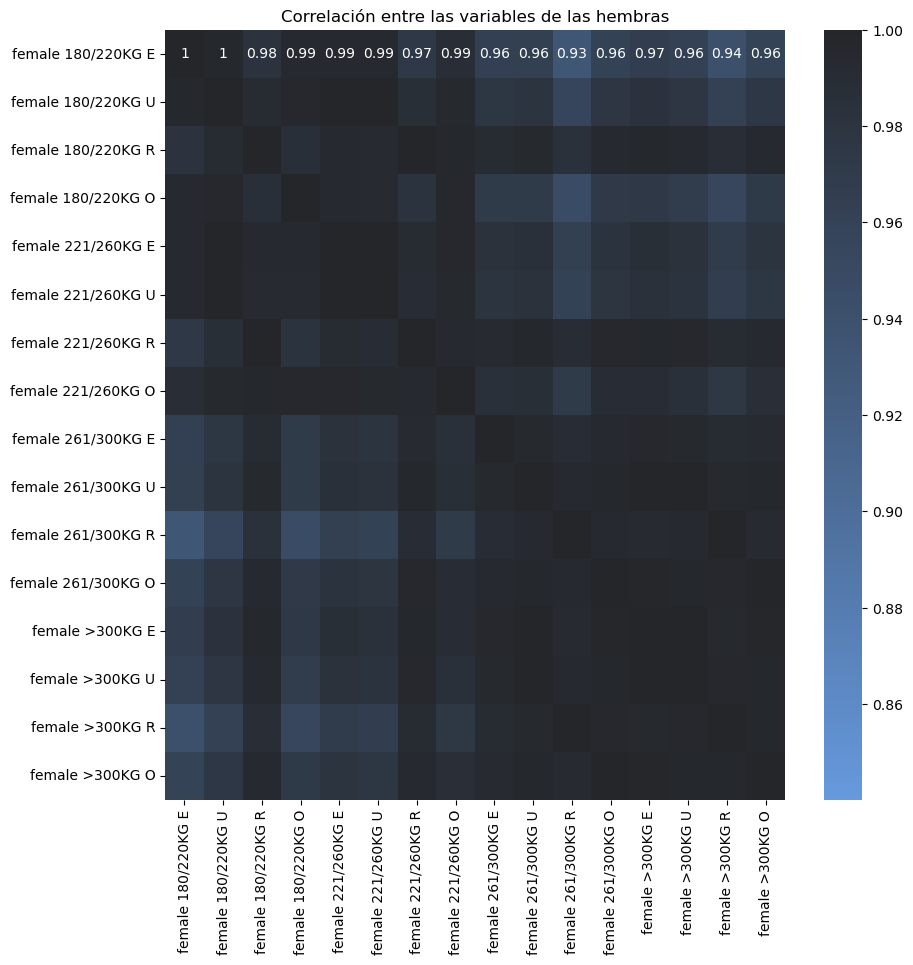

In [9]:
%%skip_if skip_cell
# Mostramos las correlaciones de nuevo sin outliers
# Pero dividido en 'male' y 'female'

# Datos sólo con 'male'
df_combined_male = df_combined[df_combined.columns[df_combined.columns.str.contains(r'\bmale\b') | (df_combined.columns == 'date')]]
df_combined_male_data = df_combined_male.drop(columns=['date'])
correlation_male = df_combined_male_data.corr()

# Datos sólo con 'female'
df_combined_female = df_combined[df_combined.columns[df_combined.columns.str.contains('female') | (df_combined.columns == 'date')]]
df_combined_female_data = df_combined_female.drop(columns=['date'])
correlation_female = df_combined_female_data.corr()

# Obtenemos los límites de la escala de color
vmin = min(correlation.min().min(), correlation.min().min())
vmax = max(correlation.max().max(), correlation.max().max())

# Visualización de las correlaciones
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_male, annot=True, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True), vmin=vmin, vmax=vmax)
plt.title('Correlación entre las variables de los machos')
plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_female, annot=True, cmap=sns.dark_palette("#69d", reverse=True, as_cmap=True), vmin=vmin, vmax=vmax)
plt.title('Correlación entre las variables de las hembras')
plt.show()


Tras dividir los gráficos de correlación en dos, uno para machos y otro para hembras, se puede observar que la correlación entre los productos es extremadamente alta, llegando incluso a un 1 en ciertos casos.

Una vez preparados los datos históricos de precios, procedemos a juntarlos con los datos vectoriales de los documentos de texto que aportan contexto a los precios. Primero, vamos a mosstrar brevemente la estructura de los datos de los documentos de texto.

In [10]:
%%skip_if skip_cell
# Una vez preparados los datos históricos de precios, procedemos a 
# juntarlos con los datos vectoriales de los documentos de texto que 
# aportan contexto a los precios. 
# Primero, vamos a mostrar brevemente la estructura de los datos de 
# los documentos de texto.
pdf_file = open('./datos/comentarios_procesados/comentario_2020-01-06.pdf', 'rb')
pdf_reader = PyPDF2.PdfReader(pdf_file)
text = ''
for page in pdf_reader.pages:
    text += page.extract_text()

# Las secciones de productos están separadas por '*- '
paragraphs = text.split('*- ')

# Mostramos una parte de la primera sección (ignorando la introducción),
# la cual es Ganado Vacuno
print(paragraphs[1][0:885])


GANADO VACUNO:   Machos Cruzados: repiten cotización. Frisones: suben +3 céntimos.  
Hembras: E/U, +3 céntimos. R/O, repiten cotización. 
Primera Sesión de Lonja del 2020, que viene arrastrando todos los festivos navideños hasta llegar al día dos.  
Todavía es pronto para ver la situación del mercado en el mes de enero, por lo tanto semana de transición,  
prudencia y repetición de precios en los machos cruzados. No sucede lo mismo con los frisones, que suben con  
fuerza, o con algunas hembras que suben pero con más dificultad.
A partir de ahora tenemos que ver cómo está el mercado, si las últimas ventas han limpiado los censos de peso  
en las explotaciones y si las ventas continúan ágiles durante este primer mes del año, sobre todo la exportación  
vía barco que es de la que se espera más movimientos para que todo fluya. Es difícil hoy coger el termómetro  
del mercado.


Estos documentos de texto contienen información sobre el contexto socioeconómico y político que puede influir en los precios de la lonja. Para poder trabajar con estos datos, se ha utilizado un modelo de lenguaje preentrenado, Llama, que permite obtener una representación vectorial de los documentos de texto. Estos vectores se han guardado en un archivo JSON donde se asocia cada vector con su correspondiente fecha.

In [11]:
%%skip_if skip_cell
# Cargamos el fichero con los vectores de los documentos de texto
# './datos/embeddings.json'
with open('./datos/embeddings.json', 'r') as file:
    embeddings = json.load(file)

# Mostramos el 'shape' de los vectores
len(embeddings[0]['embeddings'][0])

3072

En el caso de Llama, los vectores tienen una longitud de 3072, una cantidad muy alta respecto al número de datos históricos que tenemos, por lo que más adelante se procederá a reducir la dimensión de los vectores.

Una vez obtenidos los vectores, se procede a juntarlos con los datos históricos de precios. Para ello, se ha creado un archivo CSV donde se asocia cada vector con su correspondiente fecha.

In [12]:
%%skip_if skip_cell
# Leemos los archivos CSV y JSON
df_data = pd.read_csv('./datos/combinado.csv', sep=',')
df_data['date'] = pd.to_datetime(df_data['date'], utc=True)
df_embeddings = pd.read_json('./datos/embeddings.json')
df_embeddings['date'] = pd.to_datetime(df_embeddings['date'], utc=True)

# Unir los DataFrames por la columna 'date'
df_merged = df_data.merge(df_embeddings, left_on='date', right_on='date')

# Guardar el DataFrame unido en un archivo CSV
df_merged.to_csv('./datos/datos_embeddings.csv', index=False)
df_merged.head(1)

,date,male <280KG E,male <280KG U,male <280KG R,male <280KG O,male 281/320KG E,male 281/320KG U,male 281/320KG R,male 281/320KG O,male 321/370KG E,...,female 221/260KG O,female 261/300KG E,female 261/300KG U,female 261/300KG R,female 261/300KG O,female >300KG E,female >300KG U,female >300KG R,female >300KG O,embeddings
0,2020-01-06 00:00:00+00:00,4.59,4.42,4.05,3.75,4.57,4.4,4.0,3.75,4.46,...,4.36,4.83,4.7,4.37,4.13,4.79,4.66,4.35,4.09,"[[0.15832200646400402, 0.13162529468536302, 0...."


In [13]:
%%skip_if skip_cell
df_merged.describe()

,male <280KG E,male <280KG U,male <280KG R,male <280KG O,male 281/320KG E,male 281/320KG U,male 281/320KG R,male 281/320KG O,male 321/370KG E,male 321/370KG U,...,female 221/260KG R,female 221/260KG O,female 261/300KG E,female 261/300KG U,female 261/300KG R,female 261/300KG O,female >300KG E,female >300KG U,female >300KG R,female >300KG O
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,...,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,5.122264,4.990283,4.726321,4.422925,5.089434,4.968255,4.700236,4.420896,5.029858,4.898443,...,4.997075,4.617123,5.229245,5.116651,4.862925,4.520943,5.212264,5.099292,4.849151,4.504198
std,0.406754,0.467057,0.548801,0.544095,0.436068,0.469158,0.567919,0.542675,0.486852,0.505532,...,0.367310,0.320577,0.395253,0.403307,0.471266,0.385315,0.403082,0.408340,0.458764,0.384095
min,4.480000,4.250000,3.880000,3.580000,4.400000,4.230000,3.830000,3.580000,4.260000,4.100000,...,4.330000,3.910000,4.630000,4.500000,4.170000,3.910000,4.590000,4.460000,4.150000,3.910000
25%,4.730000,4.552500,4.182500,3.882500,4.670000,4.532500,4.132500,3.882500,4.562500,4.402500,...,4.660000,4.360000,4.840000,4.710000,4.370000,4.140000,4.830000,4.700000,4.397500,4.130000
50%,5.190000,5.125000,4.950000,4.720000,5.175000,5.110000,4.950000,4.720000,5.150000,5.090000,...,4.950000,4.590000,5.180000,5.090000,4.875000,4.525000,5.170000,5.060000,4.820000,4.490000
75%,5.490000,5.382500,5.212500,4.932500,5.462500,5.342500,5.192500,4.922500,5.450000,5.302500,...,5.400000,4.960000,5.660000,5.580000,5.380000,4.950000,5.650000,5.560000,5.340000,4.930000
max,5.670000,5.610000,5.440000,5.060000,5.710000,5.600000,5.430000,5.060000,5.710000,5.590000,...,5.450000,5.060000,5.720000,5.610000,5.450000,4.970000,5.710000,5.610000,5.430000,4.960000


Se puede apreciar una gran pérdida en los datos, ya que comenzábamos con 496 registros con los datos históricos, y tras la unión con los vectores, nos quedamos con 212 registros, lo que supone una pérdida total del 57,26%. Esto se debe a que la lonja comenzó a desarrollar los documentos de texto en 2020, por lo que no tenemos datos de los años anteriores.

Esto es un problema, ya que los datos de los años anteriores pueden ser muy importantes para predecir los precios de la lonja y se trata de una pérdida muy grande. 

## Preparación de los datos

Una vez recogidos los datos, se procede a prepararlos para poder ser utilizados en los modelos de aprendizaje automático. Esta tarea consiste en elegir la variable a predecir y separar los datos en un conjunto de entrenamiento y otro de test. El conjunto de entrenamiento se utilizará para entrenar los modelos, mientras que el conjunto de test se utilizará para evaluar el rendimiento de los modelos y decidir cuál es el mejor.

In [13]:
# Leemos los datos
df_data = pd.read_csv('./datos/datos_embeddings.csv')
# Convertimos la columna 'date' a datetime
df_data['date'] = pd.to_datetime(df_data['date'])

# Elegimos la variable a predecir
y_target_name = 'male 281/320KG E'
# Añadimos la columna 'Target-1' en la penúltima posición
df_data['Target-1'] = df_data[y_target_name]
df_data = df_data[[col for col in df_data if col != 'embeddings'] + ['embeddings']]
# Eliminamos los registros con nulos
df_data = df_data.dropna()
# Ponemos la columna a predecir en la última posición
df_data = df_data[[col for col in df_data if col != y_target_name] + [y_target_name]]

In [14]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    """
    Divide una secuencia de datos en datos de entrada (X) y de salida (y).
    :param sequence: secuencia de datos
    :param n_steps_in: número de pasos de entrada (tamaño de la ventana)
    :param n_steps_out: número de pasos de salida (número de valores a predecir)
    :return: datos de entrada, datos de salida
    """
    X, emb_l, y = list(), list(), list()

    for i in range(len(sequence)):
        # Buscamos el final de la secuencia
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # Comprobamos si hemos llegado al final de la secuencia
        if out_end_ix > len(sequence):
            break
        # Separamos los datos de entrada y de salida
        # La salida es el último valor de la secuencia (última columna)
        seq_x, seq_emb, seq_y = sequence[i:end_ix,1:-2], sequence[i:end_ix,-2], sequence[end_ix:out_end_ix,-1]
        seq_emb = [ast.literal_eval(item)[0] for item in seq_emb]
        X.append(seq_x)
        emb_l.append(seq_emb)
        y.append(seq_y)
    return np.array(X), np.array(emb_l), np.array(y)

n_steps_in = 4 # Número de pasos de entrada (tamaño de la ventana)
output_size = 1 # Número de valores a predecir
# Dividimos los datos en datos de entrada y de salida
X, emb, y = split_sequence(df_data.values, n_steps_in, output_size)

# Dividimos los datos de entrada y de salida en entrenamiento y test
X_train, X_test, emb_train, emb_test, y_train, y_test = train_test_split(
    np.array(X).astype('float32'), 
    np.array(emb).astype('float32'), 
    np.array(y).astype('float32'), 
    test_size=0.2, 
    shuffle=False, 
    random_state=0
)

## Definición de los modelos

Antes de comenzar a construir nuestro modelo para procesar los datos, necesitamos un modelo previo con el que comparar los resultados. El modelo previo se trata de un modelo de redes neuronales recurrentes (RNN) con una capa LSTM. Este modelo se ha elegido por ser un modelo sencillo y que ha demostrado ser efectivo en problemas de series temporales. A continuación se define el modelo a utilizar.

In [16]:
def modelo_previo(input_shape, output_shape=1):
	"""
	Crea un modelo de red neuronal con una capa LSTM y dos capas densas.
	:param input_shape: forma de los datos de entrada
	:param output_shape: forma de los datos de salida
	:return: modelo de red neuronal
	"""
	input = tf.keras.layers.Input(shape=input_shape)

	# Capa LSTM
	lstm0 = tf.keras.layers.LSTM(32, activation='tanh', return_sequences=False, return_state=False, recurrent_activation='relu', stateful=False)(input)

	# Capa densa
	dense0 = tf.keras.layers.Dense(8, activation='relu')(lstm0)

	# Capa de salida
	output = tf.keras.layers.Dense(output_shape, activation='linear')(dense0)

	model = tf.keras.models.Model(inputs=input, outputs=output)
	opt = tf.keras.optimizers.AdamW(learning_rate=0.0001)
	model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])
	return model

Vamos a definir cómo queremos que sea el modelo con los vectores de los documentos de texto. Para ello, vamos a utilizar un modelo de redes neuronales recurrentes (RNN) con dos capas LSTM, una capa encargada de procesar los datos de los precios y otra capa encargada de procesar la salida de la capa anterior y los vectores de los documentos de texto. 

Dada la diferencia en el rango de valores entre los precios y los vectores de los documentos de texto, se ha añadido una capa de normalización a los datos, y se añaden varias capas ocultas en los datos vectoriales antes de unirlos con los datos de los precios, para reducir la dimensión de los vectores, que como se ha visto anteriormente, es muy alta respecto a las variables de los precios.

In [22]:
def modelo_embeddings(price_shape, emb_shape, output_shape=1):
	"""
	Crea un modelo de red neuronal con dos entradas, una para los precios y otra para los embeddings.
	La entrada de los precios pasa por una capa LSTM y la entrada de los embeddings por dos capas densas.
	Ambas entradas se concatenan y pasan por una capa LSTM y tres capas densas.
	:param price_shape: forma de los datos de precios
	:param emb_shape: forma de los datos de embeddings
	:param output_shape: forma de los datos de salida
	:return: modelo de red neuronal
	"""
	# Definimos las entradas
	input_prices = tf.keras.layers.Input(shape=price_shape, name='input_prices', batch_size=1)
	input_embeddings = tf.keras.layers.Input(shape=emb_shape, name='input_embeddings', batch_size=1)

	# Capas de los embeddings
	embeddings0 = tf.keras.layers.LayerNormalization()(input_embeddings)
	embeddings1 = tf.keras.layers.Conv1D(2048, 1, activation='tanh')(embeddings0)
	embeddings2 = tf.keras.layers.Conv1D(1024, 1, activation='tanh')(embeddings1)

	# Capas de los precios
	normalized_prices = tf.keras.layers.LayerNormalization()(input_prices)
	prices0 = tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True, return_state=False, recurrent_activation='relu', stateful=False)(normalized_prices)

	# Concatenamos las capas de los precios y los embeddings
	merged = tf.keras.layers.concatenate([prices0, embeddings2])
	lstm_merged = tf.keras.layers.LSTM(128, activation='tanh', return_sequences=False, return_state=False, recurrent_activation='relu', stateful=False)(merged)
	hidden0 = tf.keras.layers.Dense(64, activation='relu')(lstm_merged)
	hidden1 = tf.keras.layers.Dense(32, activation='relu')(hidden0)
	last_hidden = tf.keras.layers.Dense(8, activation='relu')(hidden1)

	# Capa de salida
	output = tf.keras.layers.Dense(output_shape, activation='linear')(last_hidden)

	model = tf.keras.models.Model(inputs={'input_prices': input_prices, 'input_embeddings': input_embeddings}, outputs=output)
	model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001), loss='mean_squared_error', metrics=['mse', 'mae'])
	return model

## Entrenamiento de los modelos

El entrenamiento de los modelos es prácticamente idéntico, con la diferencia del uso de los vectores de los documentos de texto, ya que el modelo previo para poder comparar los resultados sólo utiliza los precios.

Para entrenar los modelos, se ha utilizado el conjunto de entrenamiento que se ha separado anteriormente. Además, se utiliza la técnica de 'early stopping' para evitar el sobreajuste de los modelos, esta técnica detiene el entrenamiento si no se mejora el rendimiento del modelo en un número determinado de épocas.

Como métrica para evaluar el rendimiento de los modelos durante el entrenamiento, se ha utilizado el error cuadrático medio (MSE), que mide la diferencia entre los valores predichos y los valores reales. Dicha evaluación se aplica a los datos de validación, que constan del 20% de los datos de entrenamiento, dicha fracción se define al entrenar con la función ```fit```  con el parámetro ```validation_split=0.2```. La evolución de la métrica se puede observar en las gráficas de entrenamiento, cuyos valores muestran el error cuadrático medio durante el entrenamiento ("mse") y el error cuadrático medio en los datos de validación ("val_mse").

### Entrenamiento del modelo previo

Epoch 1/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.9434 - mae: 3.0492 - mse: 9.9434 - val_loss: 0.7343 - val_mae: 0.8563 - val_mse: 0.7343
Epoch 2/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0500 - mae: 0.1414 - mse: 0.0500 - val_loss: 0.0054 - val_mae: 0.0675 - val_mse: 0.0054
Epoch 3/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0447 - mae: 0.1633 - mse: 0.0447 - val_loss: 0.0044 - val_mae: 0.0610 - val_mse: 0.0044
Epoch 4/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - mae: 0.0855 - mse: 0.0135 - val_loss: 0.0203 - val_mae: 0.1075 - val_mse: 0.0203
Epoch 5/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080 - mae: 0.0474 - mse: 0.0080 - val_loss: 0.0197 - val_mae: 0.1124 - val_mse: 0.0197
Epoch 6/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - mae: 0.0624 - mse: 0.0095 - val_loss: 0.0193 - val_mae: 0.1157 - val_mse: 0.0193
Epoch 7/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105 - mae: 0.067

<Axes: >

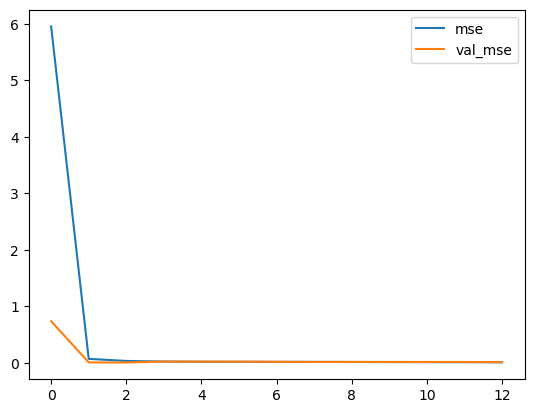

In [23]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.keras.random.SeedGenerator(RANDOM_SEED)
# Creamos el modelo
input_shape_prices = (X_train.shape[1], X_train.shape[2])  # (n_steps_in, n_features_prices)
input_shape_embeddings = (emb_train.shape[1],emb_train.shape[2])  # n_features_embeddings
model_prev = modelo_previo(input_shape_prices, y_train.shape[1])
# Configuramos EarlyStopping
patience = 10
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=patience, verbose=0, mode='min', restore_best_weights=True)
# Entrenamos el modelo
epochs = 10000
history_prev = model_prev.fit(
    X_train,
    y_train,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    validation_split=0.2,
    callbacks=[earlyStopping],
    batch_size=1
)
pd.DataFrame(history_prev.history)[['mse','val_mse']].plot()

### Entrenamiento del modelo con los vectores

Epoch 1/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 4.3976 - mae: 1.3836 - mse: 4.3976 - val_loss: 0.0343 - val_mae: 0.1758 - val_mse: 0.0343
Epoch 2/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.1272 - mae: 0.2583 - mse: 0.1272 - val_loss: 0.0395 - val_mae: 0.1869 - val_mse: 0.0395
Epoch 3/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.1279 - mae: 0.2637 - mse: 0.1279 - val_loss: 0.0378 - val_mae: 0.1833 - val_mse: 0.0378
Epoch 4/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.1276 - mae: 0.2629 - mse: 0.1276 - val_loss: 0.0378 - val_mae: 0.1832 - val_mse: 0.0378
Epoch 5/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0933 - mae: 0.1926 - mse: 0.0933 - val_loss: 0.0140 - val_mae: 0.0877 - val_mse: 0.0140
Epoch 6/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.1480 - mae: 0.2711 - mse: 0.1480 - val_loss: 0.0226 - val_mae: 0.1441 - val_mse: 0.0226
Epoch 7/10000
132/132 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.138

<Axes: >

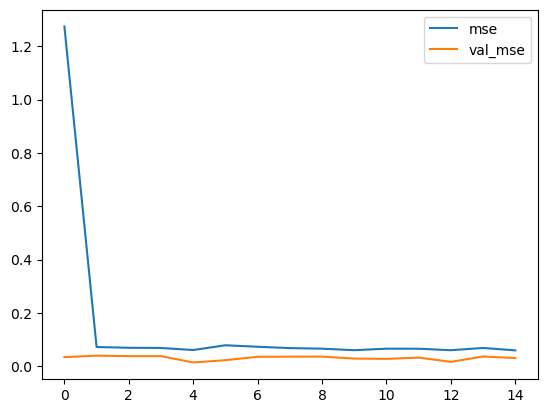

In [24]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.keras.random.SeedGenerator(RANDOM_SEED)
# Creamos el modelo
input_shape_prices = (X_train.shape[1], X_train.shape[2])  # (n_steps_in, n_features_prices)
input_shape_embeddings = (emb_train.shape[1],emb_train.shape[2])  # n_features_embeddings
model_emb = modelo_embeddings(input_shape_prices, input_shape_embeddings, y_train.shape[1])
# Configuramos EarlyStopping
patience = 10
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=patience, verbose=0, mode='min', restore_best_weights=True)
# Entrenamos el modelo
epochs = 10000
history_emb = model_emb.fit(
    {
        'input_prices': X_train,
        'input_embeddings': emb_train
    },
    y_train,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    validation_split=0.2,
    callbacks=[earlyStopping],
    batch_size=1
)
pd.DataFrame(history_emb.history)[['mse','val_mse']].plot()

## Evaluación de los modelos

Dado que estamos tratando un problema de series temporales, se ha tomado la decisión de evaluar los modelos como si estuviesen funcionando en producción, es decir, se ha utilizado el conjunto de test para predecir los precios de forma semanal con un reentrenamiento del modelo tras efectuar la predicción. De esta forma, se ha podido evaluar el rendimiento de los modelos en un escenario real.

La implementación que lleva a cabo la simulación de producción es idéntica para ambos modelos, con excepción del uso de los embeddings de los documentos de texto.

In [25]:
def retrain_every_week(X_test, y_test, horizon, model):
    """
    Simula un entorno de producción donde se predice cada
    'horizon' semanas y se reentrena el modelo cada semana.
    :param X_test: datos de entrada de test
    :param y_test: datos de salida de test
    :param horizon: número de semanas a predecir
    :param model: modelo de red neuronal
    :return: predicciones
	"""
    predictions = []
    for i in range(0, len(y_test), horizon):
        # Predecimos 'horizon' semanas
        predictions.extend(model.predict(X_test[i:i+horizon], verbose=0))
        earlyStopping = tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, monitor='loss')
        # Reentrenamos el modelo con las 'horizon' semanas
        model.fit(
            X_test[i:i+horizon],
            y_test[i:i+horizon],
            epochs=1000,
            shuffle=False,
            verbose=0,
            callbacks=[earlyStopping],
            batch_size=1
            )
    return predictions

def retrain_every_week_emb(X_test, emb_test, y_test, horizon, model):
    """
    Simula un entorno de producción donde se predice cada
    'horizon' semanas y se reentrena el modelo cada semana.
    :param X_test: datos de entrada de test
    :param emb_test: datos de entrada de test
    :param y_test: datos de salida de test
    :param horizon: número de semanas a predecir
    :param model: modelo de red neuronal
    :return: predicciones
	"""
    predictions = []
    for i in range(0, len(y_test), horizon):
        # Predecimos 'horizon' semanas
        predictions.extend(model.predict({'input_prices': X_test[i:i+horizon], 'input_embeddings': emb_test[i:i+horizon]}, verbose=0))
        earlyStopping = tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, monitor='loss')
        # Reentrenamos el modelo con las 'horizon' semanas
        model.fit(
            {
                'input_prices': X_test[i:i+horizon], 
                'input_embeddings': emb_test[i:i+horizon]
             }, 
            y_test[i:i+horizon], 
            epochs=1000, 
            shuffle=False, 
            verbose=0, 
            callbacks=[earlyStopping],
            batch_size=1
            )
    return predictions

In [26]:
def metricas(y_test,y_pred):
    print('----------------------------------------------')
    #print("Accuracy score on test set is {}".format(r2_score(y_test,y_pred)))
    print('----------------------------------------------')
    print("R2:", round(r2_score(y_test, y_pred),5))
    print("MAE:",round(mean_absolute_error(y_test, y_pred),7))
    print("MSE:", round(mean_squared_error(y_test,y_pred),7))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test,y_pred)),7))
    
    print('----------------------------------------------')
    # Calculate the absolute errors
    errors = abs(np.array(y_pred) - np.array(y_test))
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (np.array(errors) / np.array(y_test))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 4), '%.') 
    # Calculate max error
    max_error = np.max(errors)
    print('Max Error:', round(max_error, 2))
    
def plot_comparison(y_test, y_pred):
    # Plot
    plt.figure(figsize=(18, 6))
    plt.plot(y_test, label='Real')
    plt.plot(y_pred, label='Predict')
    plt.title('Test retrained every week')
    plt.legend()
    plt.show()
    plt.figure(figsize=(18, 6))
    plt.plot(y_test, label='Real')
    plt.plot(np.roll(y_pred, -1), label='Predict shifted')
    plt.title('Shifted')
    plt.legend()
    plt.show()
    # Metrics
    metricas(y_test,y_pred)

### Evaluación del modelo previo

Procedemos a evaluar los modelos en entornos de producción, para ello, se ha utilizado el conjunto de test para predecir los precios de forma semanal con un reentrenamiento del modelo tras efectuar la predicción. De las predicciones hechas por los modelos ("Predict"), se calculan las métricas y se comparan con los valores reales ("Real") en dos gráficas, la primera con las predicciones ("Test retrained every week") y la segunda con las predicciones movidas una semana (hacia atrás) para comprobar si existe sobreajuste en los modelos ("Shifted").

In [27]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.keras.random.SeedGenerator(RANDOM_SEED)
y_pred_prev = retrain_every_week(X_test, y_test, 1, model_prev)

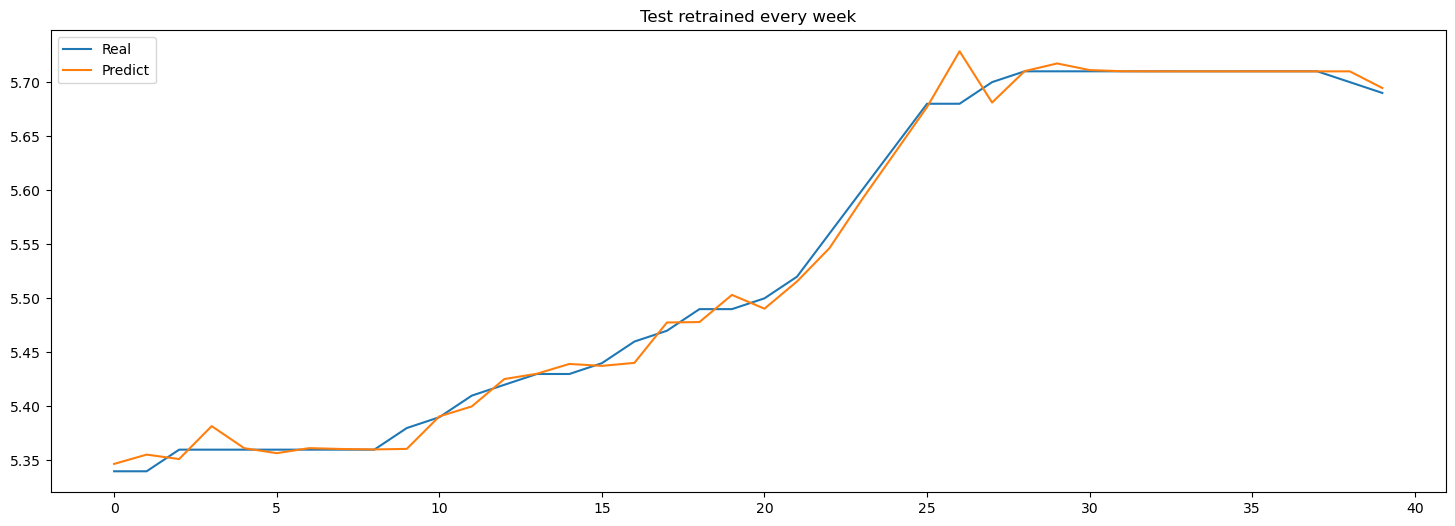

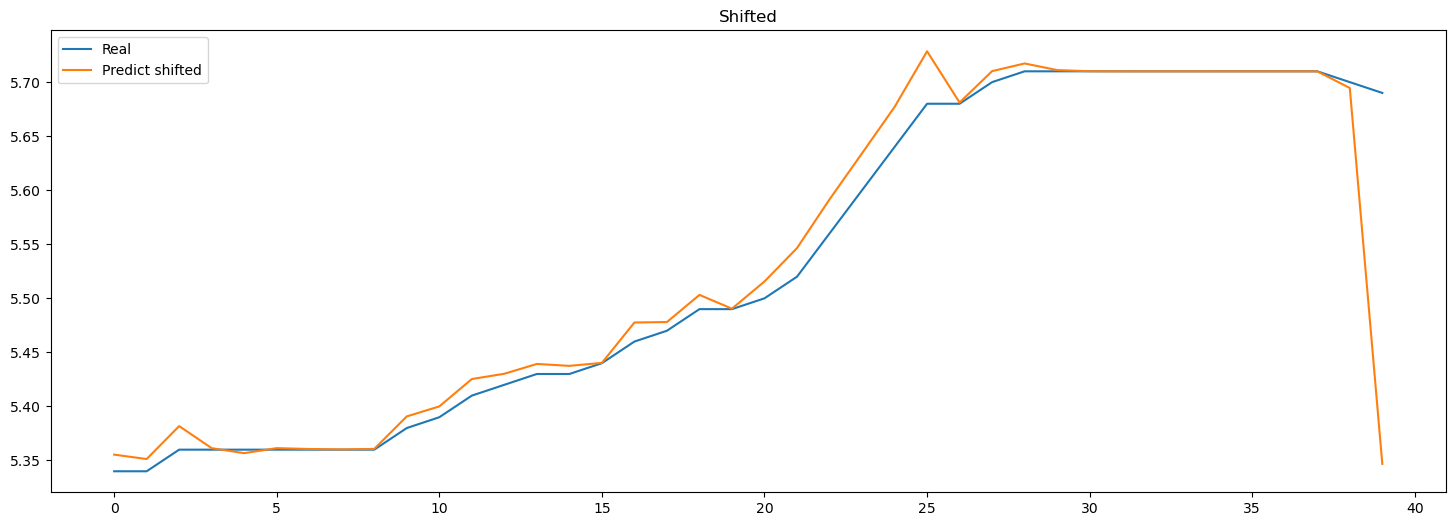

----------------------------------------------
----------------------------------------------
R2: 0.99355
MAE: 0.0073767
MSE: 0.0001376
RMSE: 0.0117285
----------------------------------------------
Accuracy: 99.8663 %.
Max Error: 0.05


In [28]:
plot_comparison(y_test[2:], y_pred_prev[2:])

Las métricas obtenidas con este modelo son las siguientes:

<div align="center">

| R2 | MAE | MSE | RMSE | Accuracy | Error Máximo |
|----|-----|-----|------|-----------|-------------|
| 0.99355 | 0.0073767 | 0.0001376 | 0.0117285 | 99.8663 % | 0.05 € |

</div>

### Evaluación del modelo con los vectores

In [29]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.config.experimental.enable_op_determinism()
tf.keras.random.SeedGenerator(RANDOM_SEED)
y_pred_emb = retrain_every_week_emb(X_test, emb_test, y_test, 1, model_emb)

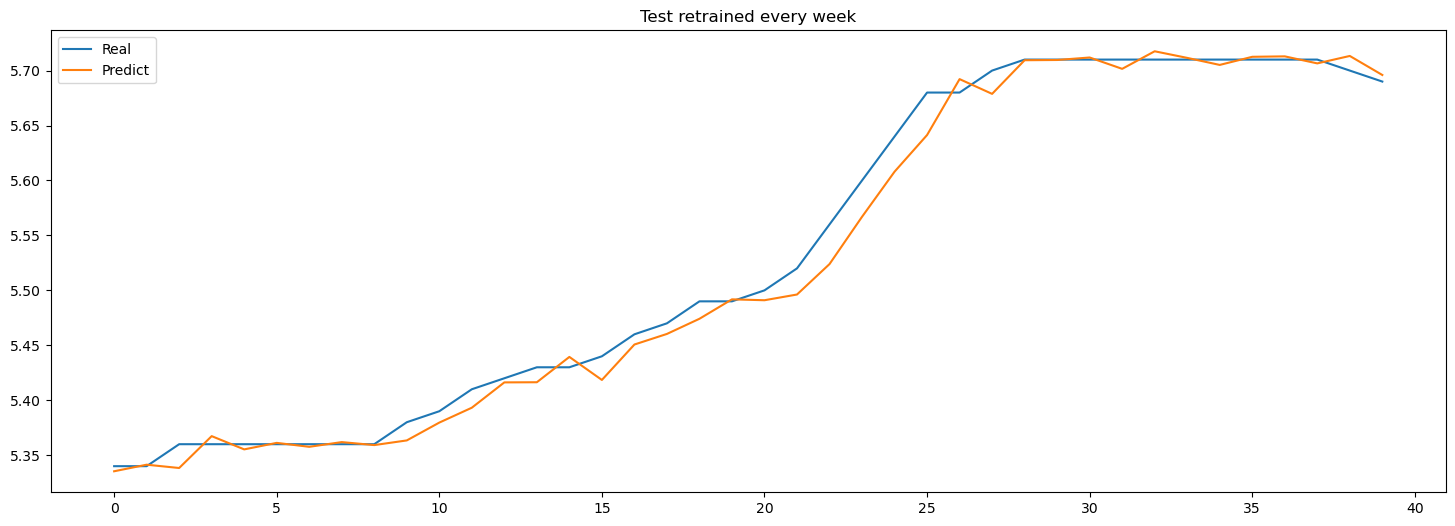

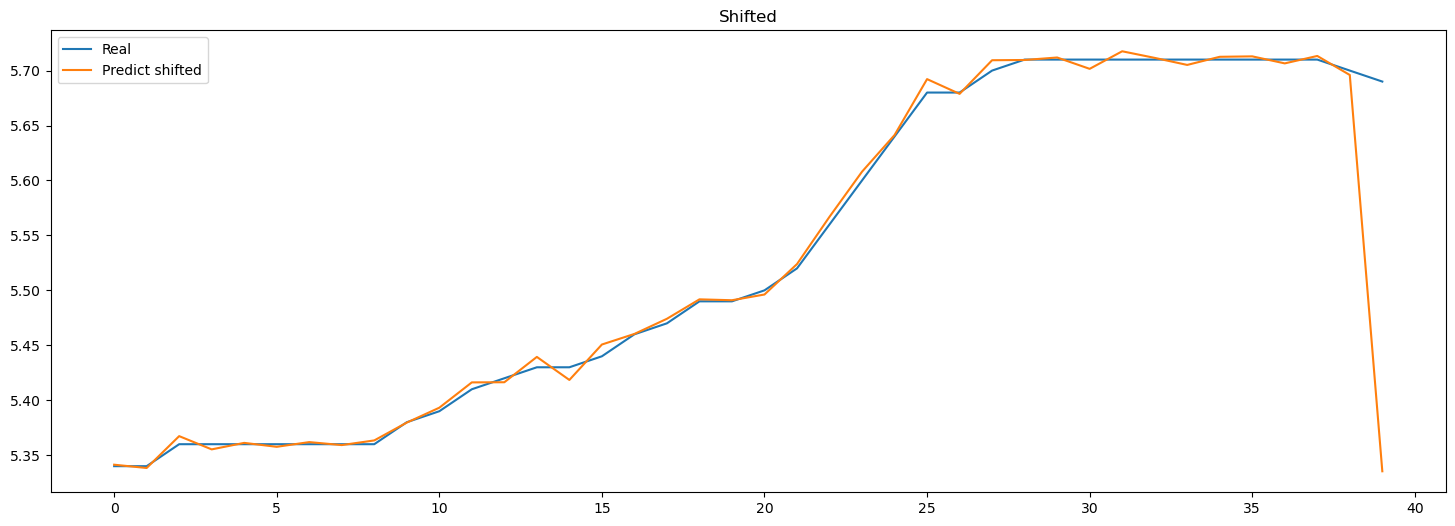

----------------------------------------------
----------------------------------------------
R2: 0.98947
MAE: 0.010852
MSE: 0.0002246
RMSE: 0.0149882
----------------------------------------------
Accuracy: 99.8042 %.
Max Error: 0.04


In [30]:
plot_comparison(y_test[2:], y_pred_emb[2:])

Las métricas obtenidas con este modelo son las siguientes:

<div align="center">

| R2 | MAE | MSE | RMSE | Accuracy | Error Máximo |
|----|-----|-----|------|-----------|--------------|
| 0.98947 | 0.010852 | 0.0002246 | 0.0149882 | 99.8042 % | 0.04 € |

</div>

### Mejora del modelo

Podemos comprobar con el gráfico comparativo y con las métricas que el nuevo modelo no solo no ha mejorado el rendimiento del modelo previo, sino que ha empeorado. Por lo tanto, se ha decidido utilizar la librería Optuna para optimizar los hiperparámetros y el número de capas del modelo con embeddings, y con el mejor modelo obtenido tras la optimización, se procede a comparar los resultados con el modelo previo.

El modelo objetivo se define de la siguiente forma:

In [ ]:
def build_model(trial, X_shape, emb_shape):
    """
    Construye un modelo de red neuronal con los hiperparámetros y
    arquitectura definidos por Optuna.
    :param trial: objeto de Optuna
    :param X_shape: forma de los datos de los precios
    :param emb_shape: forma de los datos de los embeddings
    :return: modelo de red neuronal
    """
    model = tf.keras.Sequential()
    input_price = tf.keras.layers.Input(shape=X_shape, name='input_prices', batch_size=1)
    input_emb = tf.keras.layers.Input(shape=emb_shape, name='input_embeddings', batch_size=1)

    # Embeddings
    num_layers_emb = trial.suggest_int('num_layers_emb', 1, 5)
    emb0 = tf.keras.layers.LayerNormalization()(input_emb)
    for i in range(num_layers_emb):
        units = trial.suggest_int(f'emb_units_{i}_emb', 128, 2048)
        activations = trial.suggest_categorical(f'emb_activation_{i}_emb', ['relu', 'tanh'])
        emb0 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units, activation=activations))(emb0)

    # Precios
    prices0 = tf.keras.layers.LayerNormalization()(input_price)

    # Concatenamos
    merged = tf.keras.layers.concatenate([prices0, emb0])
    
    lstm_units0 = trial.suggest_int('lstm_units0', 16, 512)
    activations_lstm_comb = trial.suggest_categorical('activations_lstm_comb', ['tanh', 'relu'])
    recurrent_activ_lstm_comb = trial.suggest_categorical('recurrent_activ_lstm_comb', ['relu', 'tanh'])
    combined = tf.keras.layers.LSTM(lstm_units0, activation=activations_lstm_comb, return_sequences=False, recurrent_activation=recurrent_activ_lstm_comb)(merged)

    # Capas Ocultas
    num_layers_hid = trial.suggest_int('num_layers_hid', 1, 5)
    for i in range(num_layers_hid):
        units = trial.suggest_int(f'units_{i}', 8, 256)
        activations_hid = trial.suggest_categorical(f'activations_{i}_hid', ['relu', 'tanh'])
        combined = tf.keras.layers.Dense(units, activation=activations_hid)(combined)
    last_hidden = tf.keras.layers.Dense(8, activation='relu')(combined)
    
    # Capa de salida
    output = tf.keras.layers.Dense(1, activation='linear')(last_hidden)
    
    model = tf.keras.Model(inputs={'input_prices': input_price, 'input_embeddings': input_emb}, outputs=output)
    learning_rates = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rates)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

Y la definición de los estudios de Optuna es la siguiente:

In [ ]:
%%skip_if skip_cell
def retrain_every_week_emb_optuna(X_test, emb_test, y_test, horizon, model):
    """
    Simula un entorno de producción donde se predice cada
    'horizon' semanas y se reentrena el modelo cada semana.
    :param X_test: datos de entrada de test
    :param emb_test: datos de entrada de test
    :param y_test: datos de salida de test
    :param horizon: número de semanas a predecir
    :param model: modelo de red neuronal
    :return: predicciones, error absoluto medio
	"""
    predictions = []
    mae_mean = []
    for i in range(0, len(y_test), horizon):
        preds = model.predict({'input_prices': X_test[i:i+horizon], 'input_embeddings': emb_test[i:i+horizon]}, verbose=0)
        predictions.extend(preds.flatten())
        earlyStopping = tf.keras.callbacks.EarlyStopping(
            patience=5, restore_best_weights=True, monitor='loss')
        history = model.fit(
            {'input_prices': X_test[i:i+horizon], 
             'input_embeddings': emb_test[i:i+horizon]
             }, 
             y_test[i:i+horizon], 
             epochs=1000, 
             shuffle=False, 
             verbose=0, 
             callbacks=[earlyStopping],
             batch_size=1)
        mae_mean.append(np.mean(history.history['mae']))
    mae_mean = np.mean(mae_mean)
    return predictions, mae_mean

# Optuna
y_pred_list = []
def objective(trial):
    """
    Función objetivo para Optuna.
    :param trial: objeto de Optuna
    :return: error absoluto medio durante test
	"""
    # Modelo
    model = build_model(trial, X_train.shape[1:], emb_train.shape[1:])
    # Entrenamiento
    patience = 15
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model.fit(
        {'input_prices': X_train, 'input_embeddings': emb_train},
        y_train,
        validation_split=0.2,
        epochs=10000,
        batch_size=1,
        callbacks=[early_stopping],
        verbose=0
    )
    # Evaluación
    y_pred, mae_mean = retrain_every_week_emb_optuna(X_test, emb_test, y_test, 1, model)
    y_pred_list.append(y_pred)
    return mae_mean

# Estudio
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

Como se puede apreciar, en lugar de tener en cuenta el error durante el entrenamiento, se ha decidido utilizar el error en la simulación de producción para evaluar el rendimiento de los modelos.

Por desgracia, existen combinaciones de hiperparámetros que producen un sobreajuste del modelo, ya que se le introduce como entrada el parámetro 'Target-1', que es el precio real de la semana anterior, lo que hace el modelo es repetir el precio de la semana anterior. Dichas combinaciones de hiperparámetros, aunque están sobreajustadas, tienen un error muy bajo, ya que los datos no tienen una oscilación muy grande, y el mejor modelo obtenido con Optuna es uno de estos modelos sobreajustados.

<div align="center">

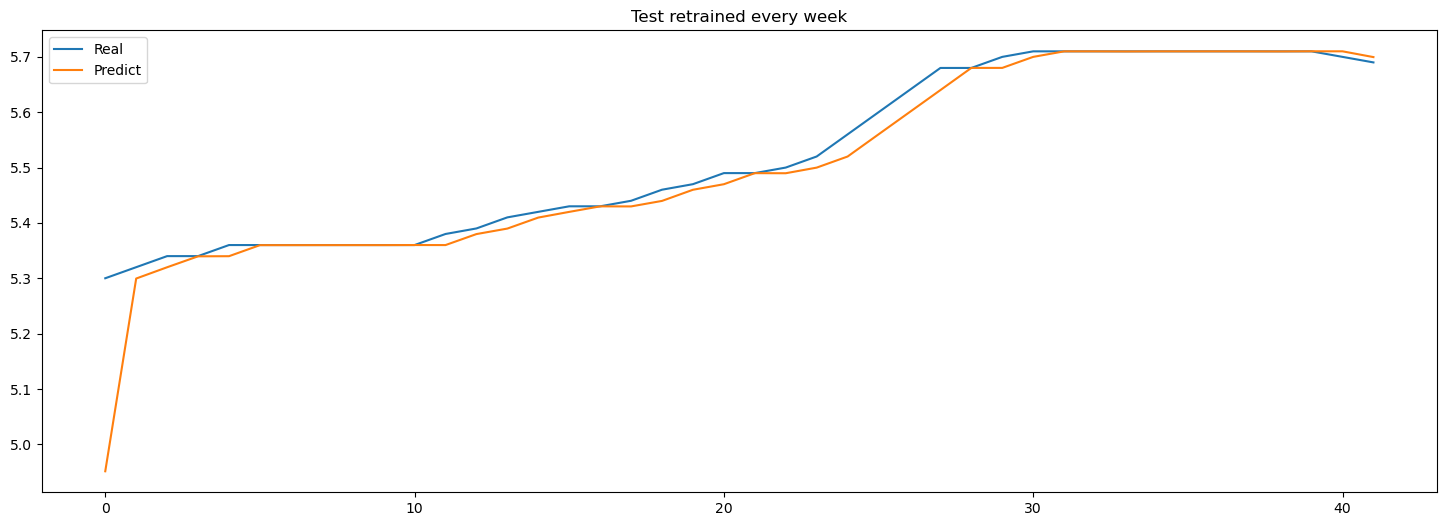

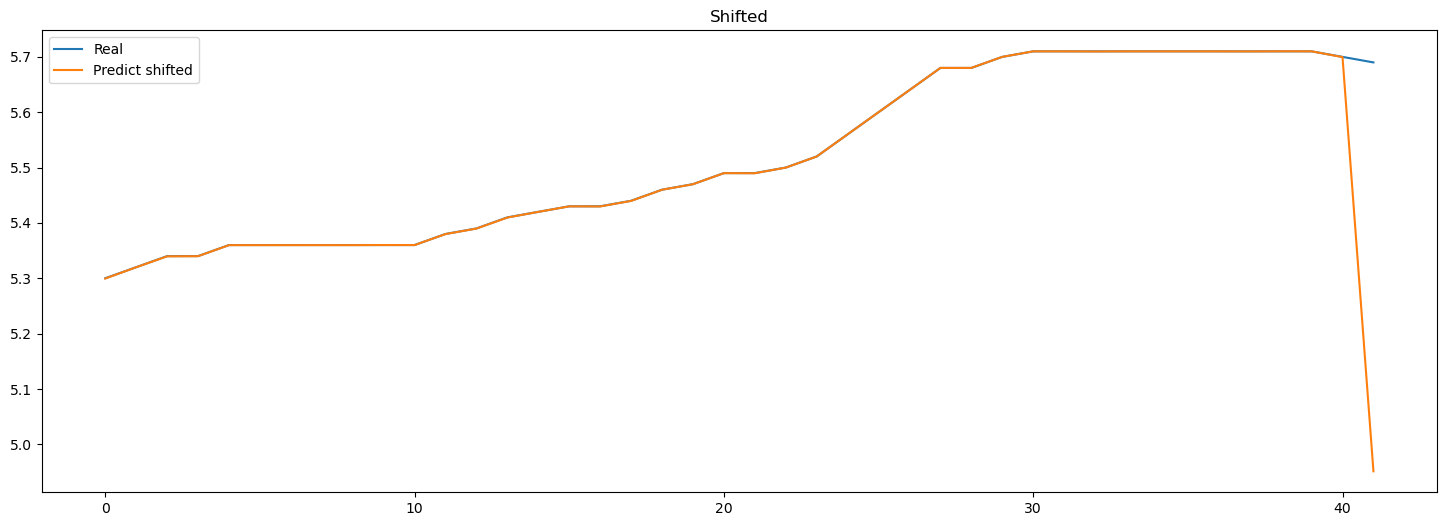

</div>

Esta situación implica una revisión de todos los modelos resultantes de utilizar Optuna, ya que no se puede confiar en que el mejor modelo sea el que mejor se ajuste a los datos.

Tras una revisión de los modelos, se ha encontrado el siguiente modelo que no está sobreajustado y que tiene un error bajo:

<div align="center">

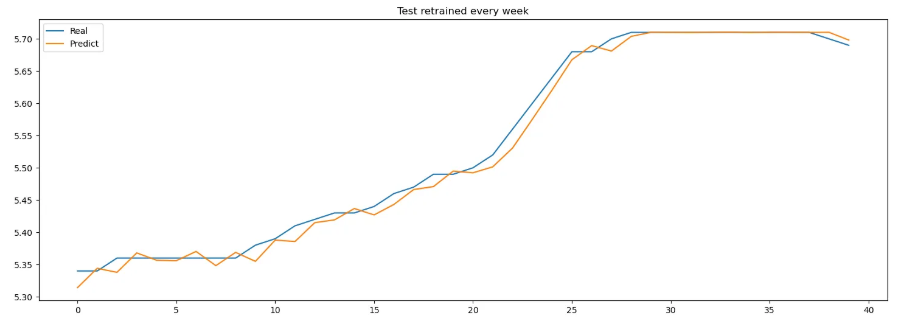

</div>

El código de este modelo es el siguiente:



In [ ]:
def modelo_optuna(price_shape, emb_shape, output_shape=1):
    """
    Crea un modelo de red neuronal con dos entradas, una para los precios y otra para los embeddings.
    La entrada de los precios pasa por una capa LSTM y la entrada de los embeddings por cuatro capas densas.
    Ambas entradas se concatenan y pasan por una capa LSTM y seis capas densas.
    :param price_shape: forma de los datos de precios
    :param emb_shape: forma de los datos de embeddings
    :param output_shape: forma de los datos de salida
    :return: modelo de red neuronal
	"""
    input_prices = tf.keras.layers.Input(shape=price_shape, name='input_prices', batch_size=1)
    input_embeddings = tf.keras.layers.Input(shape=emb_shape, name='input_embeddings', batch_size=1)

    embeddings0 = tf.keras.layers.LayerNormalization()(input_embeddings)
    embeddings1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1707, activation='relu'))(embeddings0)
    embeddings2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(267, activation='relu'))(embeddings1)
    embeddings3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1173, activation='relu'))(embeddings2)

    normalized_prices = tf.keras.layers.LayerNormalization()(input_prices)
    prices0 = tf.keras.layers.LSTM(155, activation='tanh', return_sequences=True, return_state=False, recurrent_activation='relu', stateful=False)(normalized_prices)
    
    merged = tf.keras.layers.concatenate([prices0, embeddings3])
    
    lstm_merged = tf.keras.layers.LSTM(363, activation='tanh', return_sequences=False, return_state=False, recurrent_activation='tanh', stateful=False)(merged)
    hidden0 = tf.keras.layers.Dense(166, activation='tanh')(lstm_merged)
    hidden1 = tf.keras.layers.Dense(94, activation='tanh')(hidden0)
    hidden2 = tf.keras.layers.Dense(254, activation='relu')(hidden1)
    hidden3 = tf.keras.layers.Dense(239, activation='tanh')(hidden2)
    hidden4 = tf.keras.layers.Dense(104, activation='relu')(hidden3)

    last_hidden = tf.keras.layers.tf.keras.layers.Dense(8, activation='relu')(hidden4)
    output = tf.keras.layers.Dense(output_shape, activation='linear')(last_hidden)

    model = tf.keras.models.Model(inputs={'input_prices': input_prices, 'input_embeddings': input_embeddings}, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00012388048454112986), loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

Con las siguientes métricas:

<div align="center">

| R2 | MAE | MSE | RMSE | Accuracy | Error Máximo |
|----|-----|-----|------|-----------|--------------|
| 0.99195 | 0.00985 | 0.0001717 | 0.0131053 | 99.8205 % | 0.03 € |

</div>

## Resultados

Tras la evaluación de los modelos, se puede concluir que el modelo previo es un modelo muy efectivo para predecir los precios de la lonja de Binéfar. Mientras que el modelo inicial que incluye los documentos de texto no ha mejorado el rendimiento del modelo previo, sino que ha empeorado, aunque el error máximo es menor, se ha decidido utilizar la optimización de hiperparámetros y número de capas con Optuna para intentar obtener un modelo con un rendimiento superior, lo cual se ha conseguido.

A continuación se muestra una tabla con las métricas de los modelos:

<div align="center">

| Modelo | R2 | MAE | MSE | RMSE | Accuracy | Error Máximo |
| --- | --- | --- | --- | --- | --- | --- |
| Modelo previo | **0.99355** |**0.0073767** | **0.0001376** | **0.0117285** | **99.8663 %** | 0.05 € |
| Modelo con embeddings | 0.98947 | 0.010852 | 0.0002246 | 0.0149882 | 99.8042 % | 0.04 € |
| Modelo optimizado | 0.99195 | 0.00985 | 0.0001717 | 0.0131053 | 99.8205 % | **0.03 €** |

</div>

Como último apunte de los resultados, se puede observar que ambos modelos que utilizan los vectores de los documentos de texto tienen un error máximo menor que el modelo previo, lo cual podría ser un indicador de que los documentos de texto aportan información relevante para la predicción de los precios en situaciones extremas, donde el conocimiento de los precios anteriores no es suficiente para predecir el precio futuro.

## Conclusiones

En este trabajo se ha realizado un análisis de los datos históricos de precios de la Lonja de Binéfar y se ha estudiado la correlación entre las variables, la distribución de los datos y se ha corregido un error en los datos. Además, se han unido los datos históricos con los vectores de los documentos de texto que aportan contexto a los precios.

Se ha definido un modelo previo y un modelo con los vectores de los documentos de texto, y se ha entrenado y evaluado ambos modelos en un escenario real, simulando la producción de los precios semanales. Se ha observado que el modelo previo es más efectivo que el modelo con los vectores de los documentos de texto, lo que ha llevado a la decisión de utilizar Optuna para optimizar los hiperparámetros del modelo previo. Tras la optimización, se ha obtenido un modelo que, aunque no mejora el rendimiento del modelo previo, obtiene un rendimiento muy similar y un error máximo menor.

Por último, cabe recalcar que dada la complejidad del problema y de los datos, es necesario seguir investigando para mejorar los modelos y obtener mejores resultados, ya que este trabajo es sólo una primera aproximación al uso de datos históricos apoyados por documentos de texto para llevar a cabo predicciones. Además, sería interesante estudiar la posibilidad de utilizar otros modelos y técnicas de aprendizaje automático para comparar los resultados obtenidos en este trabajo y las opciones para poder utilizar los datos de los años anteriores, como por ejemplo con técnicas de imputación, interpolación o generación de datos.